# PREDICT REALISED VOLATILITY

TODOs
- Try MAPE and MASE as metrics
- Conformal Predictions 

## 0. Setup and Configuration

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

import sys
import os
sys.path.append(os.path.abspath('..'))


from src.data import load_data, download_data, compute_features
from src.lstm import train_lstm, evaluate_lstm
from utils.tscv import run_tscv, run_fixed_window_tscv, run_lstm_tscv


# Set seeds for reproducibility
random_state = 42
torch.manual_seed(random_state)
np.random.seed(random_state)

# Global Variables
TRADING_WEEK = 5
TRADING_MONTH = 21
TRADING_YEAR = 252

In [2]:
feature_cols = [
    "LogReturn",
    "RealisedVolatility",
    "RSI_14",
    "BB_Width",
    "MACD",
    "YZVolatility",
    "Log_CO",
    "Log_HL",
]
ticker = "TSLA"
start_date = "2015-01-01"
seq_len = 30

In [3]:
(X_train, y_train, dates_train), (X_val, y_val, dates_val), (X_test, y_test, dates_test) = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.7,
    test_size=0.15,
)
# Print shapes of the datasets
print(f"Train shape: {len(X_train)}")
print(f"\t Train X shape: {X_train.shape}")
print(f"\t Train y shape: {y_train.shape}")
print(f"\t Train dates shape: {dates_train.shape}")
print(f"Validation shape: {len(X_val) if X_val is not None else 0}")
print(f"Test shape: {len(X_test)}\n")

# Print date ranges
print(f"Train dates:      {dates_train[0]} to {dates_train[-1]}")
if X_val is not None:
    print(f"Validation dates: {dates_val[0]} to {dates_val[-1]}")
print(f"Test dates:       {dates_test[0]} to {dates_test[-1]}")

[*********************100%***********************]  1 of 1 completed

Train shape: 1887
	 Train X shape: (1887, 30, 8)
	 Train y shape: (1887,)
	 Train dates shape: (1887,)
Validation shape: 404
Test shape: 405

Train dates:      2015-03-18 to 2022-09-13
Validation dates: 2022-09-14 to 2024-04-23
Test dates:       2024-04-24 to 2025-12-03


## 1. Explotary Analysis

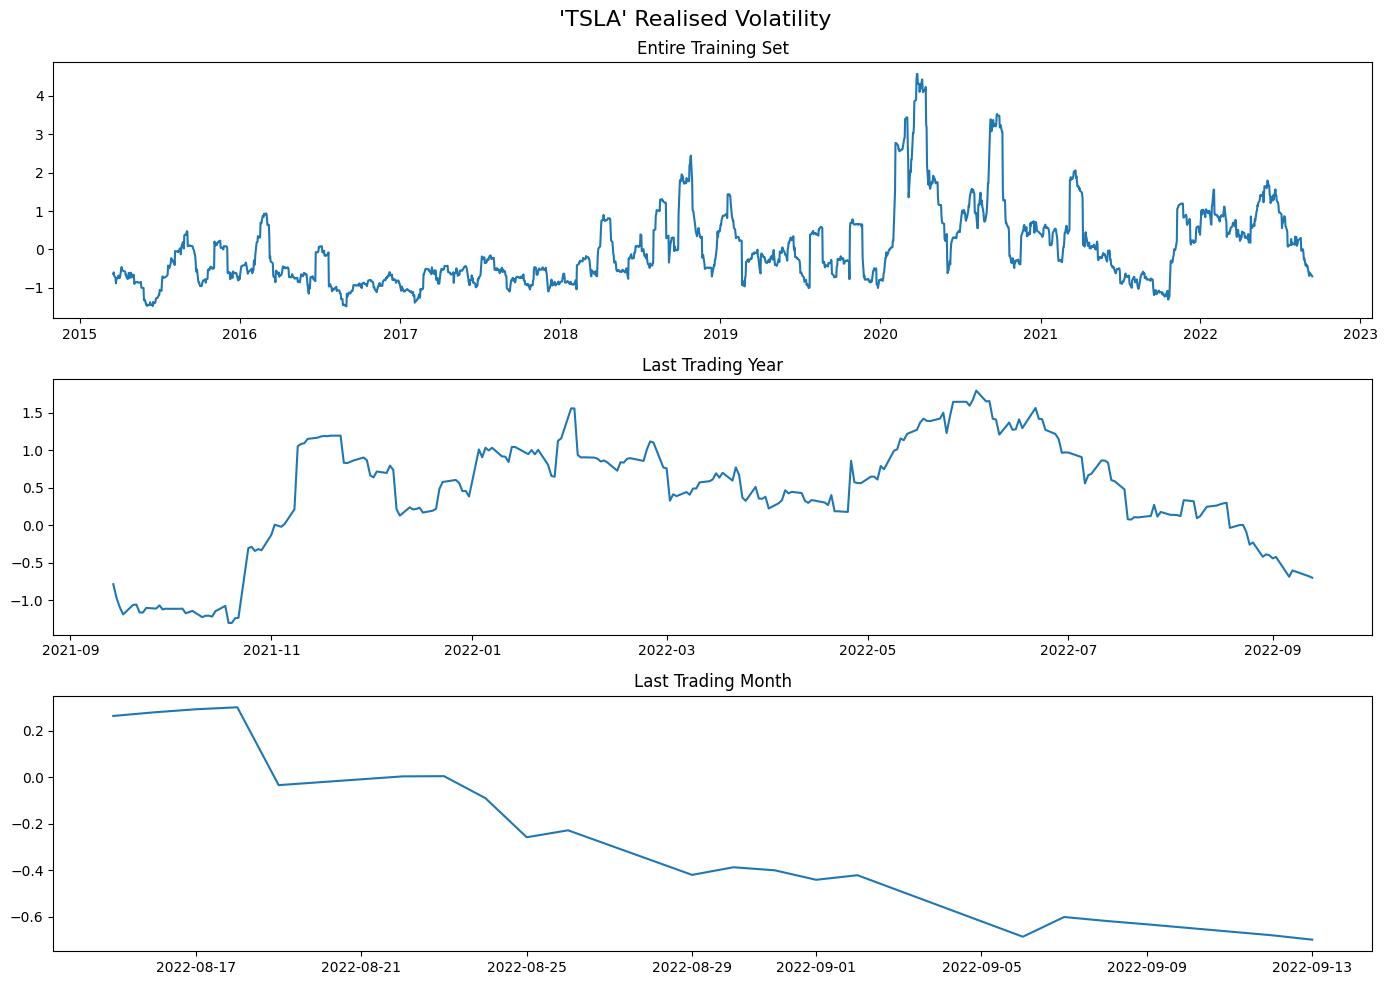

In [5]:
# 2) Basic plots: entire series, one month, a couple of days
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
# Title for the entire figure
fig.suptitle(f'\'{ticker}\' Realised Volatility', fontsize=16)
# Plot entire training set
ax[0].plot(dates_train, y_train, label='Realised Volatility')
ax[0].set_title('Entire Training Set')
# Zoom into last trading year (last available in training set)
ax[1].plot(dates_train[-TRADING_YEAR:], y_train[-TRADING_YEAR:], label='Realised Volatility')
ax[1].set_title('Last Trading Year')
# Zoom into last month
ax[2].plot(dates_train[-TRADING_MONTH:], y_train[-TRADING_MONTH:], label='Realised Volatility')
ax[2].set_title('Last Trading Month')
plt.tight_layout()
plt.show()

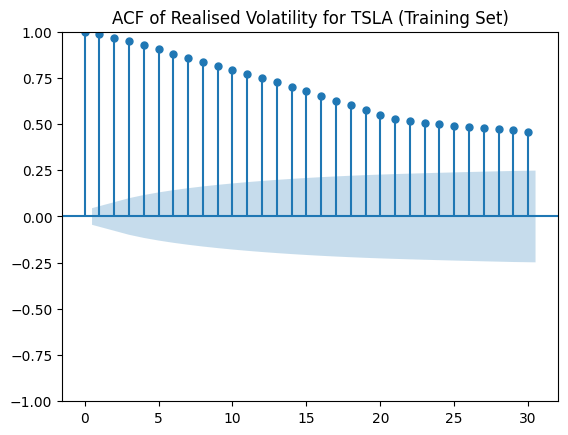

In [6]:
# Plot ACF of the target variable in the training set
plot_acf(y_train, lags=30)
plt.title(f'ACF of Realised Volatility for {ticker} (Training Set)')
plt.show()

## 2. Baseline Models
### 2.1 Naive Model

Naive Baseline:
	'Test' MAE:  0.101601
	'Test' RMSE: 0.217496


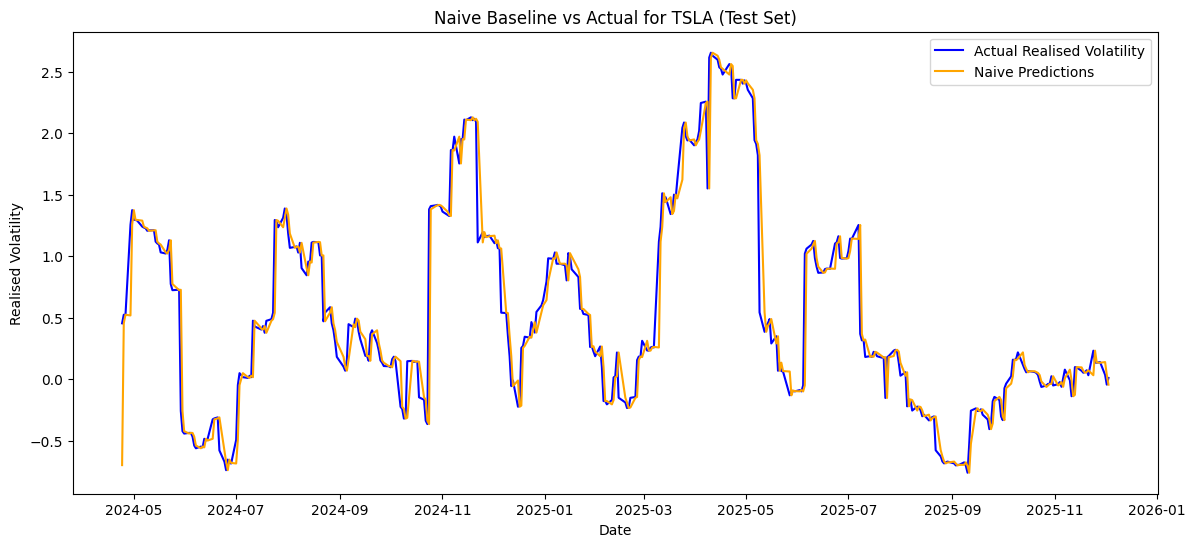

In [7]:
# naive: y_pred[t] = y[t-1]
base_preds = np.empty_like(y_test)

# first test prediction = last training value
base_preds[0] = y_train[-1]

# the rest use previous test values
base_preds[1:] = y_test[:-1]

base_mae = mean_absolute_error(y_test, base_preds)
base_rmse = np.sqrt(mean_squared_error(y_test, base_preds))

print(f"Naive Baseline:")
print(f"\t'Test' MAE:  {base_mae:.6f}")
print(f"\t'Test' RMSE: {base_rmse:.6f}")

# Plot naive predictions vs actuals
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual Realised Volatility', color='blue')
plt.plot(dates_test, base_preds, label='Naive Predictions', color='orange')
plt.title(f'Naive Baseline vs Actual for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

Such low values of MAE and RMSE might seem surprising, but if we look at the autocorrelation coefficient of the 1st lag below (also seen in the ACF plot), we can see that there is a very high correlation (0.99) between the current value and the previous value. This means that using the previous value as a prediction is quite effective in this case.

In [8]:
print(f"Autocorrelation Coefficient for lag 1 = {pd.Series(y_train.ravel()).autocorr(lag=1):.4f}")

Autocorrelation Coefficient for lag 1 = 0.9851


### 2.2 HAR-RV

Heterogenous Autoregressive Model for Realized Volatility (HAR-RV) is frequently used to model and forecast realized volatility. The HAR-RV model captures the long-memory property of volatility by incorporating realized volatility over different time horizons (daily, weekly, monthly) as predictors.

1. Intuition:
    Core idea: financial markets are heterogeneous, with participants operating on different time scales (short, medium and long-term traders)
2. Model Specification:
    The HAR-RV model can be expressed mathematically as:
    $$
    RV_{t+1} = \beta_0 + \beta_d RV_t^{(d)} + \beta_w RV_t^{(w)} + \beta_m RV_t^{(m)} + \epsilon_{t+1}
    $$
    Where:
    - $RV_t^{(d)} = RV_t$ is yesterday's RV.
    - $RV_t^{(w)} = \frac{1}{5} \sum_{i=0}^{4} RV_{t-i}$ is the average RV over the past week.
    - $RV_t^{(m)} = \frac{1}{22} \sum_{i=0}^{21} RV_{t-i}$ is the average RV over the past month.
    - $\beta_0, \beta_d, \beta _w, \beta_m$ are the model coefficients to be estimated.

In [9]:
rv = pd.Series(y_train.ravel(), index=dates_train)
rv_test = pd.Series(y_test.ravel(), index=dates_test)
full_rv = pd.concat([rv, rv_test])

lags = [1, 5, 22]  # daily, weekly, monthly
# Daily Lag
full_rv_lag0 = full_rv.shift(lags[0])

# Weekly Lag
full_rv_lag1 = full_rv.rolling(window=lags[1]).mean().shift(1)

# Monthly Lag
full_rv_lag2 = full_rv.rolling(window=lags[2]).mean().shift(1)

har_data = pd.DataFrame({
    'RV': full_rv,
    f'RV_Lag{lags[0]}': full_rv_lag0,
    f'RV_Lag{lags[1]}': full_rv_lag1,
    f'RV_Lag{lags[2]}': full_rv_lag2,
}).dropna()

train_len = len(rv)  # index to split train/test
rows_dropped = len(full_rv) - len(har_data)  # rows dropped due to NaNs
split_point_in_har = train_len - rows_dropped  # adjust split index
har_train = har_data.iloc[:split_point_in_har]
har_test = har_data.iloc[split_point_in_har:]

In [10]:
import statsmodels.api as sm

lag_names = [f"RV_Lag{lag}" for lag in lags]

X_train_har = har_train[lag_names]
y_train_har = har_train["RV"]

X_train_har = sm.add_constant(X_train_har)

har_model = sm.OLS(y_train_har, X_train_har).fit()

# print(har_model.summary())

In [11]:
X_test_har = har_test[lag_names]
X_test_har = sm.add_constant(X_test_har)

har_preds = har_model.predict(X_test_har)

HAR-RV Model:
	'Test' MAE:  0.103382
	'Test' RMSE: 0.215720


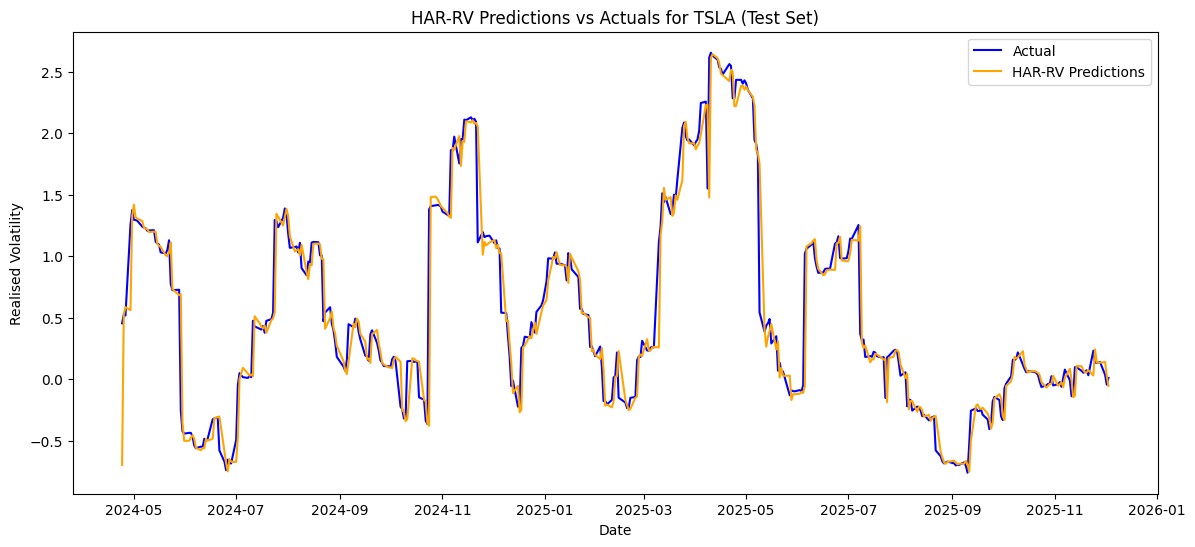

In [12]:
har_mae  = mean_absolute_error(har_test["RV"], har_preds)
har_rmse = np.sqrt(mean_squared_error(har_test["RV"], har_preds))

print(f"HAR-RV Model:")
print(f"\t'Test' MAE:  {har_mae:.6f}")
print(f"\t'Test' RMSE: {har_rmse:.6f}")

plt.figure(figsize=(14, 6))
plt.plot(har_test.index, har_test["RV"], label='Actual', color='blue')
plt.plot(har_test.index, har_preds, label='HAR-RV Predictions', color='orange')
plt.title(f'HAR-RV Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()


## 3. Machine Learning Models

### 3.1 Random Forest Regressor

In [13]:
(X_train_rf, y_train_rf, dates_train_rf), _, (X_test_rf, y_test_rf, dates_test_rf) = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=30,
    start_date=start_date,
    train_size=0.85,
    test_size=0.15,
)

n_train, seq_length, num_features = X_train_rf.shape
X_train_rf = X_train_rf.reshape(n_train, seq_length * num_features)
n_test = X_test_rf.shape[0]
X_test_rf = X_test_rf.reshape(n_test, seq_length * num_features)

print(f"\nData Shape: {X_test_rf.shape} | (n_samples, seq_len * n_features) = ({n_test}, {seq_length} * {num_features})")

[*********************100%***********************]  1 of 1 completed


Data Shape: (405, 240) | (n_samples, seq_len * n_features) = (405, 30 * 8)


Random Forest Regressor with Optimal Hyperparameters:
	Train MAE:  0.048171
	Train RMSE: 0.106530
	Test MAE:   0.117128
	Test RMSE:  0.222624


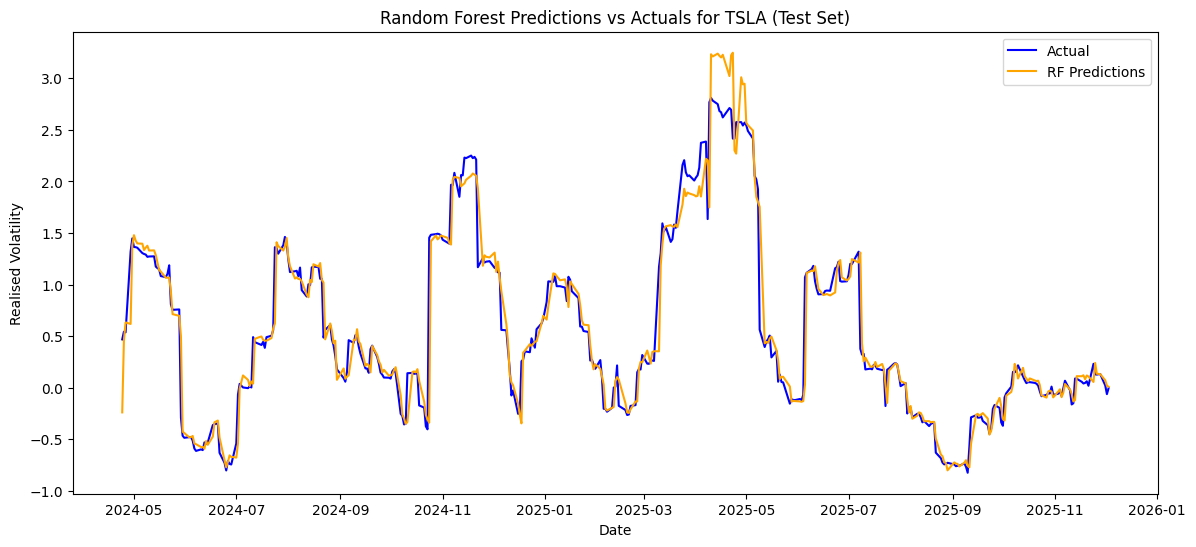

In [14]:
# Best params chosen in param_search.ipynb
# Train RF with optimal parameters on trainintg set
optimal_params = {
    'n_estimators': 300,
    'max_depth': 20,
    'min_samples_leaf': 5,
    'min_samples_split': 2,
    'random_state': 42,
    'n_jobs': -1
}
rf_best = RandomForestRegressor(**optimal_params)

rf_best.fit(X_train_rf, y_train_rf)
rf_best_train_preds = rf_best.predict(X_train_rf)
rf_best_test_preds = rf_best.predict(X_test_rf)

rf_best_train_mae = mean_absolute_error(y_train_rf, rf_best_train_preds)
rf_best_train_rmse = np.sqrt(mean_squared_error(y_train_rf, rf_best_train_preds))

rf_best_test_mae = mean_absolute_error(y_test_rf, rf_best_test_preds)
rf_best_test_rmse = np.sqrt(mean_squared_error(y_test_rf, rf_best_test_preds))

print(f"Random Forest Regressor with Optimal Hyperparameters:")
print(f"\tTrain MAE:  {rf_best_train_mae:.6f}")
print(f"\tTrain RMSE: {rf_best_train_rmse:.6f}")
print(f"\tTest MAE:   {rf_best_test_mae:.6f}")
print(f"\tTest RMSE:  {rf_best_test_rmse:.6f}")

# Plot predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(dates_test_rf, y_test_rf, label='Actual', color='blue')
plt.plot(dates_test_rf, rf_best_test_preds, label='RF Predictions', color='orange')
plt.title(f'Random Forest Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

### 3.2 LSTM

In [4]:
from src.lstm import LSTMDataset

(X_train, y_train, dates_train), _, (X_test, y_test, dates_test) = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.85,
    test_size=0.15,
)

batch_size = 32
train_ds = LSTMDataset(X_train, y_train)
val_ds   = LSTMDataset(X_val,   y_val) if X_val is not None else None
test_ds  = LSTMDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False) if val_ds else None
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


In [5]:
from src.lstm import LSTMRegressor

lstm_model = LSTMRegressor(
    input_size=len(feature_cols),
    hidden_size=32,
    num_layers=1,
    dropout=0.3
    )

model_name = f"{ticker}_best_lstm_model.pth"
metrics = train_lstm(
    lstm_model,
    train_loader=train_loader,
    val_loader=None,
    num_epochs=30,
    lr=1e-3,
    model_name=model_name
)
train_loss_history, train_rmse_history, val_loss_history, val_rmse_history, val_mase_history = metrics

lstm_model.load_state_dict(torch.load(f"../models/{model_name}"))
lstm_preds, lstm_test_mae, lstm_test_rmse = evaluate_lstm(lstm_model, test_loader, y_test)

print(f"LSTM Regressor Test MAE:  {lstm_test_mae:.6f}")
print(f"LSTM Regressor Test RMSE: {lstm_test_rmse:.6f}")

/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/30 | Train RMSE: 0.679274
Epoch 2/30 | Train RMSE: 0.344328
Epoch 3/30 | Train RMSE: 0.265382
Epoch 4/30 | Train RMSE: 0.230625
Epoch 5/30 | Train RMSE: 0.211457
Epoch 6/30 | Train RMSE: 0.198671
Epoch 7/30 | Train RMSE: 0.192304
Epoch 8/30 | Train RMSE: 0.185988
Epoch 9/30 | Train RMSE: 0.184250
Epoch 10/30 | Train RMSE: 0.177839
Epoch 11/30 | Train RMSE: 0.173539
Epoch 12/30 | Train RMSE: 0.174111
Epoch 13/30 | Train RMSE: 0.170672
Epoch 14/30 | Train RMSE: 0.171243
Epoch 15/30 | Train RMSE: 0.168633
Epoch 16/30 | Train RMSE: 0.169995
Epoch 17/30 | Train RMSE: 0.166155
Epoch 18/30 | Train RMSE: 0.165737
Epoch 19/30 | Train RMSE: 0.163438
Epoch 20/30 | Train RMSE: 0.164475
Epoch 21/30 | Train RMSE: 0.163059
Epoch 22/30 | Train RMSE: 0.162908
Epoch 23/30 | Train RMSE: 0.162769
Epoch 24/30 | Train RMSE: 0.161977
Epoch 25/30 | Train RMSE: 0.161293
Epoch 26/30 | Train RMSE: 0.160865
Epoch 27/30 | Train RMSE: 0.160722
Epoch 28/30 | Train RMSE: 0.162465
Epoch 29/30 | Train RMSE: 0.1

I tried using MASE (Mean Absolute Scaled Error) as an additional evaluation metric for the LSTM model. However, as volatility differences can be quite small, the MASE values turned out to be very large and not very informative in this context. 

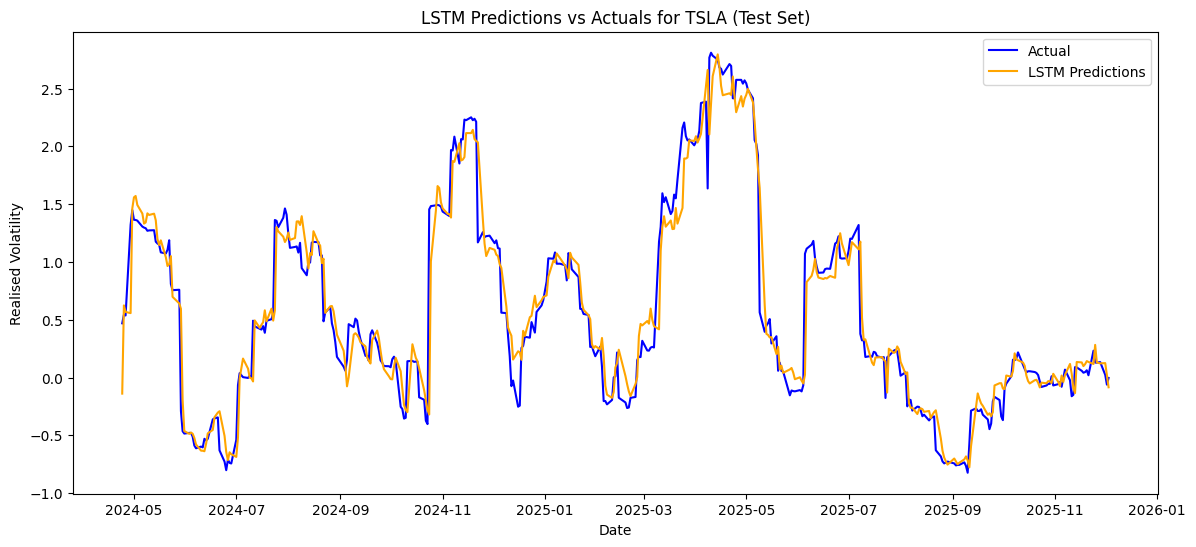

In [7]:
# Plot LSTM predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, lstm_preds, label='LSTM Predictions', color='orange')
plt.title(f'LSTM Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

## 4. Metrics Comparison

In [ ]:
# Summarize results in a DataFrame
results = pd.DataFrame({
    'Model': ['Naive Baseline', 'HAR-RV', 'Random Forest', 'LSTM Regressor'],
    'Test MAE': [base_mae, har_mae, rf_best_test_mae, lstm_test_mae],
    'Test RMSE': [base_rmse, har_rmse, rf_best_test_rmse, lstm_test_rmse],
    'MAE Ratio': [base_mae / base_mae, har_mae / base_mae, rf_best_test_mae / base_mae, lstm_test_mae / base_mae],
    'RMSE Ratio': [base_rmse / base_rmse, har_rmse / base_rmse, rf_best_test_rmse / base_rmse, lstm_test_rmse / base_rmse],
})
results

,Model,Test MAE,Test RMSE,MAE Ratio,RMSE Ratio
0,Naive Baseline,0.101513,0.217482,1.000000,1.000000
1,HAR-RV,0.103295,0.215701,1.017549,0.991814
2,Random Forest,0.115567,0.215317,1.138442,0.990047
3,LSTM Regressor,0.137448,0.217935,1.353993,1.002085


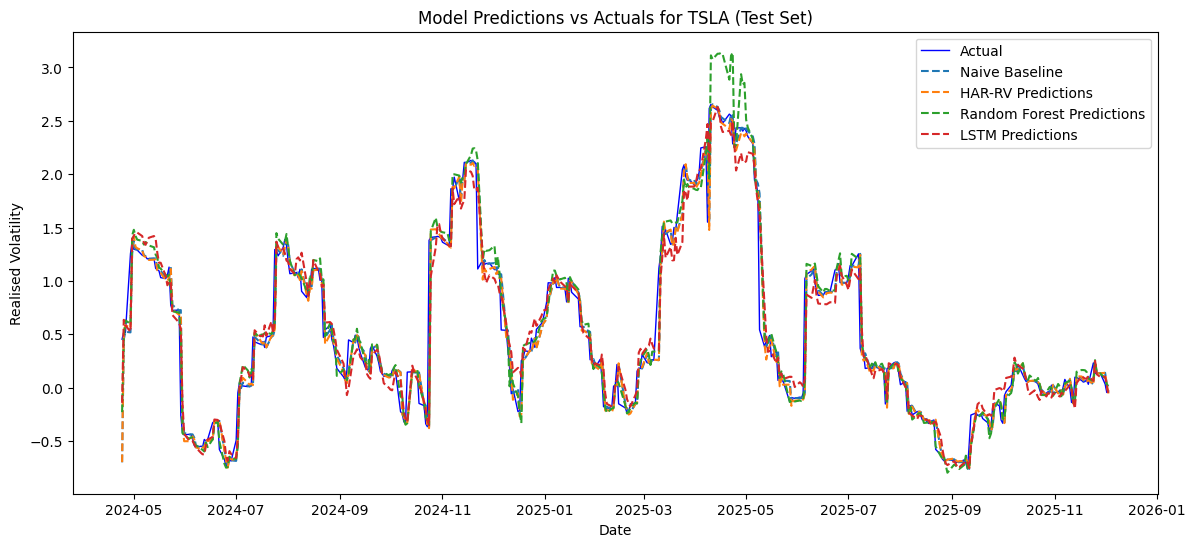

In [ ]:
# Plot all model predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue', linewidth=1)
plt.plot(dates_test, base_preds, label='Naive Baseline', linestyle='--')
plt.plot(dates_test, har_preds, label='HAR-RV Predictions', linestyle='--')
plt.plot(dates_test_rf, rf_best_test_preds, label='Random Forest Predictions', linestyle='--')
plt.plot(dates_test, lstm_preds, label='LSTM Predictions', linestyle='--')
plt.title(f'Model Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

## 5. EXPLAINABILITY

### 5.1 SHAP

#### a) Random Forest Regressor

In [ ]:
import shap

# Column names for RF input
rf_feature_names = []
for i in range(seq_length):
    for col in feature_cols:
        rf_feature_names.append(f"{col}_t-{seq_length - i}")
print(rf_feature_names[:8])
print(rf_feature_names[-8:])
X_test_rf_df = pd.DataFrame(X_test_rf, columns=rf_feature_names)

['LogReturn_t-30', 'RealisedVolatility_t-30', 'RSI_14_t-30', 'BB_Width_t-30', 'MACD_t-30', 'YZVolatility_t-30', 'Log_CO_t-30', 'Log_HL_t-30']
['LogReturn_t-1', 'RealisedVolatility_t-1', 'RSI_14_t-1', 'BB_Width_t-1', 'MACD_t-1', 'YZVolatility_t-1', 'Log_CO_t-1', 'Log_HL_t-1']


/tmp/ipykernel_1152/3075845762.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_shap, show=True)


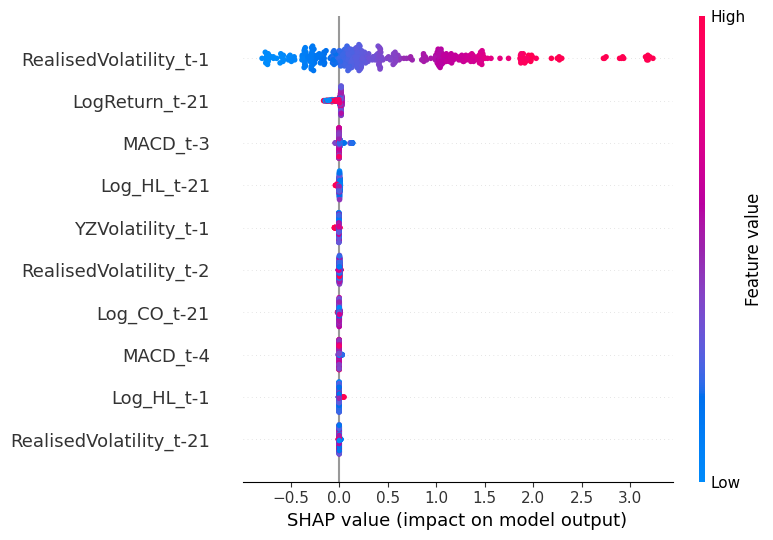

/tmp/ipykernel_1152/3075845762.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_shap, plot_type="bar", show=True)


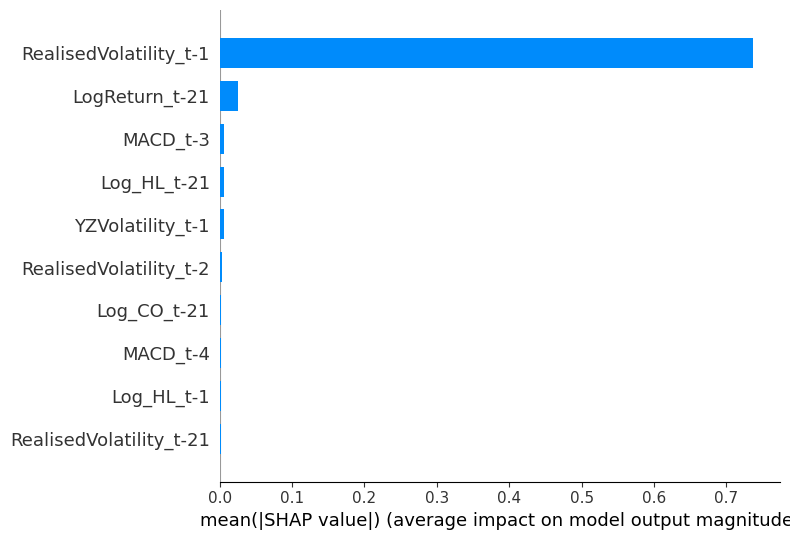

In [19]:
# Select a subset of X_test for SHAP analysis
X_shap = X_test_rf_df.sample(n=min(500, len(X_test_rf_df)), random_state=random_state)

explainer_rf = shap.TreeExplainer(rf_best)
shap_values_rf = explainer_rf.shap_values(X_shap)

# Select the 10 most relevant features based on mean absolute SHAP values
most_important_indices = np.argsort(-np.abs(shap_values_rf).mean(0))[:10]
X_shap = X_shap.iloc[:, most_important_indices]
shap_values_rf = shap_values_rf[:, most_important_indices]

shap.summary_plot(shap_values_rf, X_shap, show=True)
shap.summary_plot(shap_values_rf, X_shap, plot_type="bar", show=True)

In [27]:
idx_max = np.argmax(shap_values_rf.mean(axis=0))
print(f"Date with highest mean absolute SHAP value for RF: {X_shap.columns[idx_max]}")

Date with highest mean absolute SHAP value for RF: RealisedVolatility_t-1


#### b) LSTM

In [ ]:
from captum.attr import IntegratedGradients

sample_x = test_ds.X[:50] # First 50 samples from test set
sample_y = test_ds.y[:50]

ig = IntegratedGradients(lstm_model)
attr, delta = ig.attribute(sample_x, return_convergence_delta=True)

print("Attributions shape:", attr.shape)  

torch.Size([50, 30, 8])


/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


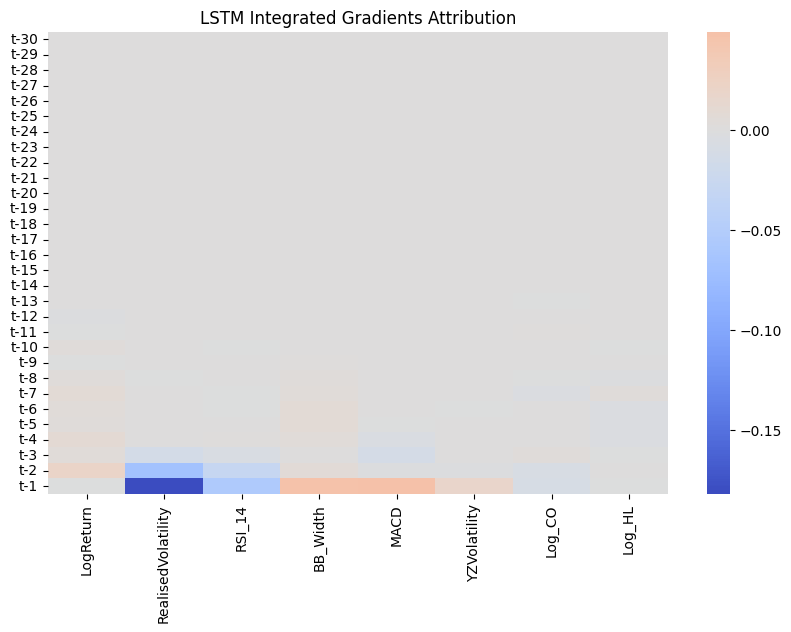

In [ ]:
attr_np = attr[0].detach().numpy()

plt.figure(figsize=(10, 6))
sns.heatmap(attr_np.T,
            xticklabels=feature_cols,
            yticklabels=[f"t-{seq_len-i}" for i in range(seq_len)],
            cmap="coolwarm",
            center=0)
plt.title("LSTM Integrated Gradients Attribution")
plt.show()